In [1]:
from __future__ import division
from math import log, exp, tan, atan, pi, ceil
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import scipy.spatial as spatial
# from mayavi import mlab
# mlab.init_notebook()
import glob
from termcolor import colored
import re
import scipy.io as sio
from scipy.interpolate import InterpolatedUnivariateSpline
import shdom

%matplotlib notebook

#  example: 808 candela/M^2  236 [Fl](Foot Lambert)
C = (1/pi)*(1/0.3048**2)# luminance/C -> from [candela/M^2] to [Fl](Foot Lambert)
# luminance*C ->  from [Fl](Foot Lambert) to [candela/M^2] 

# Implenemt Yoav's expresions

Solar irradiance is often integrated over a given time period in order to report the radiant energy emitted into the surrounding environment (joule per square metre, J/m2), during that time period

Solar radiation (sun spectral radiation) can be approximated as the radiation from a block body at 5900K.


Caclulate the argument:
\begin{align}
B_{\lambda} = \frac{2 h c^2}{\lambda^5} \frac{1}{{\rm exp}^{\frac{h c}{k T \lambda}}-1}
\end{align}

The units of $B_{\lambda}$ is $\frac{W}{m^2\cdot nm \cdot st}$. I whant the irradiance per $nm$ so I need to multiply $B_{\lambda}$ by the solid angle the the sun see the eargth, thus $E_{\lambda} = 6.8 \cdot 10^{-5} B_{\lambda}$ and it of units of $\frac{W}{m^2 \cdot nm}$.

$E_{\lambda}$ is the amount of irradiance per wavelenght that irradiat the TOA from sun.

For the VIS range I assume clouds albedo is 1. I also assume atmospheric transmission is 1 (sun->clouds,clouds->satellite).

At = pixel area at nadir = 50^2 m^2.

To calculate the irradiance for spectral range,
\begin{align}
E = \int_{\lambda_1}^{\lambda_2}E_{\lambda}(\lambda)\delta\lambda 
\end{align}

where $E$ is the irradiance of units $\frac{W}{m^2}$.

* h = 6.62607004e-34 J*s is the Planck constant
* c = 3.0e8 m/s speed of litght 
* k = 1.38064852e-23 J/K is the Boltzmann constant
* T is the temperature of the radiation cavity of the black-body.
* At is the area seen from the sattelite (at the top of the clouds).
* R is the distance from clouds to observer.
* Ao is the lens area of the CloudCT sat

* QE (pandas Dataframe): Dataframe of Quantum Efficieny of a specific channel
* QEs (list of DataFrames): Quantum Efficiency graphs of the camera in RGB order.
* ch_index (int): Color channel to process (in order [R, G, B])
* E_ph=hc\λ is photon energy, h is the Planck constant, c is the speed of light in vacuum and λ is the photon's wavelength.



constant factor should be 1395.703268036305


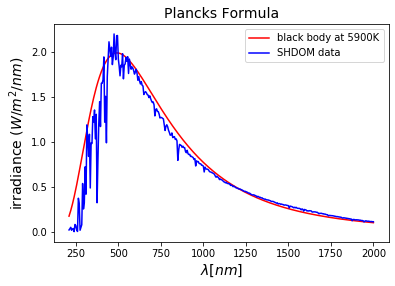

In [2]:

def plank(llambda,T):
    h = 6.62607004e-34 # Planck constant
    c = 3.0e8
    k = 1.38064852e-23 # Boltzmann constant
    # https://en.wikipedia.org/wiki/Planck%27s_law
    a = 2.0*h*(c**2)
    b = (h*c)/(llambda*k*T)
    spectral_radiance = a/ ( (llambda**5) * (np.exp(b) - 1.0) )
    return spectral_radiance

#
# Limits and density of the integraion.
#
start, end = 0.21, 2 # in micro meter [10^-6]
dlambda = 0.005
temp = 5900 #K
xspl = np.linspace(start, end, int((end - start) / dlambda)+1)

# dlambda = 0.005e-6
# wavelengths = np.arange(380e-9, 830e-9, dlambda) # my old 
wavelengths = xspl

# from https://socratic.org/questions/how-much-of-the-total-energy-that-leaves-the-sun-makes-it-to-earth-why
# Considering Sun to be situated at the centre of sphere whose radius is equal to the average distance between sun and earth
# which is 1.496×10^8km, erath radius is 6.371x10^3 km
# Solid angle subtended by the area of earth exposed to sun is SA

spectral_radiance_black_body = 6.8e-5*1e-9*plank(1e-6*wavelengths,temp) # units fo W/(m^2 nm) ,
# I am assuming a solid angle of 6.8e-5 steradian for the source (the solar disk).

plt.plot(wavelengths*1e3,spectral_radiance_black_body,color = 'r',label = 'black body at {}K'.format(temp))
plt.title("Plancks Formula", fontsize=14)
plt.xlabel("$\lambda [nm]$", fontsize=14)# sinse x axis is wavelengths*1e3
plt.ylabel("irradiance ($W/m^2/nm$)", fontsize=14)

B = np.trapz(spectral_radiance_black_body, x = xspl*1e3) # x is in nu 
print('constant factor should be {}'.format(B))

# use aviads code:
specturm = shdom.SolarSpectrum(filename='../ancillary_data/SpectralSolar_MODWehrli_1985_WMO.npz')
Aviads_specturm = specturm.get_monochrome_solar_flux(wavelengths=wavelengths)
plt.plot(wavelengths*1e3,Aviads_specturm,color = 'b',label = 'SHDOM data')
plt.legend()
# print('spectrum:{}, units: {}'.format(specturm.get_monochrome_solar_flux(wavelengths=[0.67, 0.8]), specturm.Spectral_Irradiance_units))

In [3]:
Delta_lambda = 100e-9 # nm
At = 50^2
D = 5e-3 # lens diameter in [m]
f = 1 # focal in [m]
p = 1e-6 # pixel size in [m]
A0 = np.pi*(D/2)**2
r_sat = 500e3 # in [m]
h = 6.62607004e-34 # Planck constant
c = 3.0e8
k = 1.38064852e-23 # Boltzmann constant
exPt = 6.57e-3 # sec
THETA0 = np.linspace(0.1, np.pi/4, 15)[np.newaxis]

# peaking near 564–580 nm (red); medium-wavelength, 
# peaking near 534–545 nm (green); and short-wavelength light, near 420–440 nm (blue)

# GREEN

The number of electrons that reach the pixel is 1003.931365423893


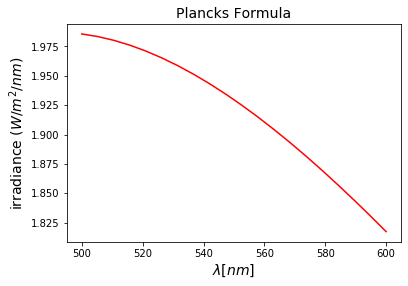

In [4]:
start, end = 0.5, 0.6 # in micro meter [10^-6]
dlambda = 0.005
xspl = np.linspace(start, end, int((end - start) / dlambda)+1)
ro = 0.3*np.ones_like(xspl)
wavelengths = xspl

spectral_radiance_black_body = 6.8e-5*1e-9*plank(1e-6*wavelengths,temp) # units fo W/(m^2 nm) ,
# I am assuming a solid angle of 6.8e-5 st for the source (the solar disk).
%matplotlib inline
plt.plot(wavelengths*1e3,spectral_radiance_black_body,color = 'r',label = 'black body')
plt.title("Plancks Formula", fontsize=14)
plt.xlabel("$\lambda [nm]$", fontsize=14)# sinse x axis is wavelengths*1e3
plt.ylabel("irradiance ($W/m^2/nm$)", fontsize=14)

# calculate radiance on the top of the cloud
B = spectral_radiance_black_body # units fo W/(m^2 nm) ,
# I = np.cos(THETA0.T)*(ro*B)/np.pi # shape of (#angles, #wavelength) it is of units W/(m^2 st nm)
I = (ro*B)/np.pi # shape of (#angles, #wavelength) it is of units W/(m^2 st nm)


# calc E, the irradiance that reach a pixel 
# which pixel? the central, thus cos(alfa)^4 = 1
alfa = 0
L = I
QE = 0.8

DPHI = I*At*((np.pi*D**2)/4)/(r_sat**2)
# E = L*(np.pi/4)*((D/f)**2)*(np.cos(alfa)**4)
PHOTON_ENERGY = (h*c)/(1e-6*wavelengths)
# Ne = (p**2)*exPt*np.trapz((E/PHOTON_ENERGY)*QE, x = xspl*1e3) # x is in nu 
Ne = exPt*np.trapz((DPHI/PHOTON_ENERGY)*QE, x = xspl*1e3) # x is in nu 
print('The number of electrons that reach the pixel is {}'.format(Ne))
GREEN = Ne

# RED

The number of electrons that reach the pixel is 1036.3247358620408


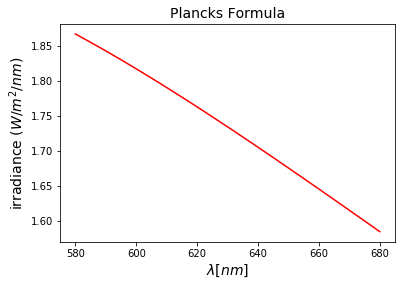

In [5]:
start, end = 0.58, 0.68 # in micro meter [10^-6]
dlambda = 0.005
xspl = np.linspace(start, end, int((end - start) / dlambda)+1)
ro = 0.3*np.ones_like(xspl)
wavelengths = xspl

spectral_radiance_black_body = 6.8e-5*1e-9*plank(1e-6*wavelengths,temp) # units fo W/(m^2 nm) ,
# I am assuming a solid angle of 6.8e-5 st for the source (the solar disk).
%matplotlib inline
plt.plot(wavelengths*1e3,spectral_radiance_black_body,color = 'r',label = 'black body')
plt.title("Plancks Formula", fontsize=14)
plt.xlabel("$\lambda [nm]$", fontsize=14)# sinse x axis is wavelengths*1e3
plt.ylabel("irradiance ($W/m^2/nm$)", fontsize=14)

# calculate radiance on the top of the cloud
B = spectral_radiance_black_body # units fo W/(m^2 nm) ,
# I = np.cos(THETA0.T)*(ro*B)/np.pi # shape of (#angles, #wavelength) it is of units W/(m^2 st nm)
I = (ro*B)/np.pi # shape of (#angles, #wavelength) it is of units W/(m^2 st nm)


# calc E, the irradiance that reach a pixel 
# which pixel? the central, thus cos(alfa)^4 = 1
alfa = 0
L = I
QE = 0.8

DPHI = I*At*((np.pi*D**2)/4)/(r_sat**2)
# E = L*(np.pi/4)*((D/f)**2)*(np.cos(alfa)**4)
PHOTON_ENERGY = (h*c)/(1e-6*wavelengths)
# Ne = (p**2)*exPt*np.trapz((E/PHOTON_ENERGY)*QE, x = xspl*1e3) # x is in nu 
Ne = exPt*np.trapz((DPHI/PHOTON_ENERGY)*QE, x = xspl*1e3) # x is in nu 
print('The number of electrons that reach the pixel is {}'.format(Ne))
RED = Ne

# BLUE

The number of electrons that reach the pixel is 826.8012641361418


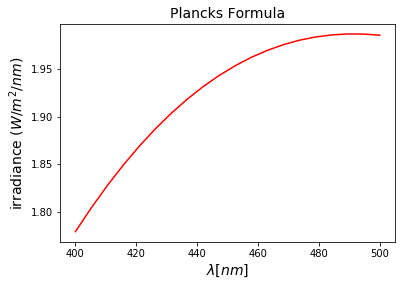

In [6]:
start, end = 0.4, 0.5 # in micro meter [10^-6]
dlambda = 0.005
xspl = np.linspace(start, end, int((end - start) / dlambda)+1)
ro = 0.3*np.ones_like(xspl)
wavelengths = xspl

spectral_radiance_black_body = 6.8e-5*1e-9*plank(1e-6*wavelengths,temp) # units fo W/(m^2 nm) ,
# I am assuming a solid angle of 6.8e-5 st for the source (the solar disk).
%matplotlib inline
plt.plot(wavelengths*1e3,spectral_radiance_black_body,color = 'r',label = 'black body')
plt.title("Plancks Formula", fontsize=14)
plt.xlabel("$\lambda [nm]$", fontsize=14)# sinse x axis is wavelengths*1e3
plt.ylabel("irradiance ($W/m^2/nm$)", fontsize=14)

# calculate radiance on the top of the cloud
B = spectral_radiance_black_body # units fo W/(m^2 nm) ,
# I = np.cos(THETA0.T)*(ro*B)/np.pi # shape of (#angles, #wavelength) it is of units W/(m^2 st nm)
I = (ro*B)/np.pi # shape of (#angles, #wavelength) it is of units W/(m^2 st nm)


# calc E, the irradiance that reach a pixel 
# which pixel? the central, thus cos(alfa)^4 = 1
alfa = 0
L = I
QE = 0.8

DPHI = I*At*((np.pi*D**2)/4)/(r_sat**2)
# E = L*(np.pi/4)*((D/f)**2)*(np.cos(alfa)**4)
PHOTON_ENERGY = (h*c)/(1e-6*wavelengths)
# Ne = (p**2)*exPt*np.trapz((E/PHOTON_ENERGY)*QE, x = xspl*1e3) # x is in nu 
Ne = exPt*np.trapz((DPHI/PHOTON_ENERGY)*QE, x = xspl*1e3) # x is in nu 
print('The number of electrons that reach the pixel is {}'.format(Ne))
BLUE = Ne

# SWIR

The number of electrons that reach the pixel is 163.9285927125737
test 163.92859271257373


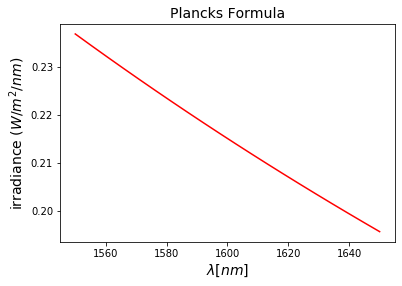

In [131]:
start, end = 1.55, 1.65 # in micro meter [10^-6]
dlambda = 0.005
xspl = np.linspace(start, end, int((end - start) / dlambda)+1)
ro = 0.15*np.ones_like(xspl)
wavelengths = xspl

spectral_radiance_black_body = 6.8e-5*1e-9*plank(1e-6*wavelengths,temp) # units fo W/(m^2 nm) ,
# I am assuming a solid angle of 6.8e-5 st for the source (the solar disk).

plt.plot(wavelengths*1e3,spectral_radiance_black_body,color = 'r',label = 'black body')
plt.title("Plancks Formula", fontsize=14)
plt.xlabel("$\lambda [nm]$", fontsize=14)# sinse x axis is wavelengths*1e3
plt.ylabel("irradiance ($W/m^2/nm$)", fontsize=14)

# calculate radiance on the top of the cloud
B = spectral_radiance_black_body # units fo W/(m^2 nm) ,
I = (ro*B)/np.pi # shape of (#angles, #wavelength) it is of units W/(m^2 st nm)

# calc E, the irradiance that reach a pixel 
# which pixel? the central, thus cos(alfa)^4 = 1
alfa = 0
L = I
QE = 0.8

DPHI = I*At*((np.pi*D**2)/4)/(r_sat**2)
# E = L*(np.pi/4)*((D/f)**2)*(np.cos(alfa)**4)
PHOTON_ENERGY = (h*c)/(1e-6*wavelengths)
# Ne = (p**2)*exPt*np.trapz((E/PHOTON_ENERGY)*QE, x = xspl*1e3) # x is in nu 
Ne = exPt*np.trapz((DPHI/PHOTON_ENERGY)*QE, x = xspl*1e3) # x is in nu 

print('The number of electrons that reach the pixel is {}'.format(Ne))
SWIR = Ne

# test math:
G = exPt*At*((np.pi)/4)/(r_sat**2)*(1/(h*c))*np.trapz((I*1e-6*wavelengths)*QE, x = xspl*1e3) # x is in nu 
Ne = (D**2)*G
print('test {}'.format(Ne))

In [132]:
[BLUE,GREEN,RED,SWIR]

[826.8012641361418, 1003.931365423893, 1036.3247358620408, 163.9285927125737]

# GENERAL

In [157]:
# UpperLimit = np.abs(wavelengths - 650*1e-9).argmin() 
# LowerLimit = np.abs(wavelengths - 400*1e-9).argmin()
# limited_wavelengths = wavelengths[LowerLimit:UpperLimit]

v= 7.61*1e3
dx = 50
r_sat = 500e3 # in [m]
SNR = 200

start, end = 0.21, 2 # in micro meter [10^-6]
dlambda_g = 0.001
xspl = np.linspace(start, end, int((end - start) / dlambda_g)+1)
wavelengths = xspl

inds = []
ro = np.array([0.3,0.3,0.15])
for el,i in enumerate([0.55,0.8,1.6]):
    ind = (np.abs(wavelengths - i).argmin())

    xspl = wavelengths[ind-5:ind+6]
#     xspl = wavelengths[ind-50:ind+51]
    print(xspl)
    spectral_radiance_black_body = 6.8e-5*1e-9*plank(1e-6*xspl,temp) # units fo W/(m^2 nm) ,

    I = (ro[el]*spectral_radiance_black_body)/np.pi # shape of (#angles, #wavelength) it is of units W/(m^2 st nm)

    # calc E, the irradiance that reach a pixel 
    # which pixel? the central, thus cos(alfa)^4 = 1
    L = I
    QE = 0.8

    G = (dx**3)*(((np.pi)/4)/(r_sat**2))*(1/(h*c*v))*np.trapz((I*1e-6*xspl)*QE, x = xspl*1e3) # x is in nu 
    D = np.sqrt(SNR**2/G)
    print('D is {}mm at {}nm'.format(D*1e2,1e3*i))

[0.545 0.546 0.547 0.548 0.549 0.55  0.551 0.552 0.553 0.554 0.555]
D is 1.3786249975291758mm at 550.0nm
[0.795 0.796 0.797 0.798 0.799 0.8   0.801 0.802 0.803 0.804 0.805]
D is 1.4317292990359975mm at 800.0nm
[1.595 1.596 1.597 1.598 1.599 1.6   1.601 1.602 1.603 1.604 1.605]
D is 3.423685210865158mm at 1600.0nm


In [122]:
spectral_radiance_black_body

array([1.77908416, 1.78400806, 1.78886644, 1.79365943, 1.79838717,
       1.80304979, 1.80764744, 1.81218028, 1.81664847, 1.82105216,
       1.82539155])

In [116]:
wavelengths[inds[0]-5:inds[0]+6]

array([0.4  , 0.401, 0.402, 0.403, 0.404, 0.405, 0.406, 0.407, 0.408,
       0.409, 0.41 ])

In [153]:
# UpperLimit = np.abs(wavelengths - 650*1e-9).argmin() 
# LowerLimit = np.abs(wavelengths - 400*1e-9).argmin()
# limited_wavelengths = wavelengths[LowerLimit:UpperLimit]
v= 7.61*1e3
dx = 50
r_sat = 500e3 # in [m]

start, end = 0.21, 2 # in micro meter [10^-6]
dlambda_g = 0.001
xspl = np.linspace(start, end, int((end - start) / dlambda_g)+1)
wavelengths = xspl


inds = []
ro = np.array([0.3,0.3,0.15])
for el,i in enumerate([0.55,0.8,1.6]):
    ind = (np.abs(wavelengths - i).argmin())
    wlambda = wavelengths[ind]
    Dlambda = 1e-9*100
    print("lamdas")
    print(wlambda)
    spectral_radiance_black_body = 6.8e-5*1e-9*plank(1e-6*wlambda,temp) # units fo W/(m^2 nm) ,
    print("black body rad")
    print(spectral_radiance_black_body)
    
    I = (ro[el]*spectral_radiance_black_body)/np.pi # shape of (#angles, #wavelength) it is of units W/(m^2 st nm)

    # calc E, the irradiance that reach a pixel 
    # which pixel? the central, thus cos(alfa)^4 = 1
    L = I
    QE = 0.8
    SNR = 200

    
    D = np.sqrt((4*v*(r_sat**2)*(h*c)*(SNR**2))/((1e9*(ro[el]*spectral_radiance_black_body)*1e-6*wlambda)*QE*(dx**3)*Dlambda))
    print('--- D is {}cm at {}nm'.format(D*1e2,1e3*i))

lamdas
0.55
black body rad
1.9296260313728326
--- D is 0.43594571752543565cm at 550.0nm
lamdas
0.7999999999999999
black body rad
1.2299644386906872
--- D is 0.452750630846842cm at 800.0nm
lamdas
1.6
black body rad
0.2150895586749353
--- D is 1.082668939173609cm at 1600.0nm


In [138]:
wlambda

1.6

In [ ]:

rte_solver = shdom.RteSolver(scene_params, numerical_params)
rte_solver.set_medium(atmosphere)
rte_solver.solve(maxiter=100)

projection = shdom.MultiViewProjection()

fov = 85.4187
sc = 10
cny= sc*ny
cnx = sc*nx

cny= 40
cnx = 40

origin = [[0.4 , 0.4 , 1.7333],
          [0.4 , 0.4, 1.7333],
          [0.0 , 0.0, 1.7333]]
          
lookat = [[0.4 , 0.4 , 1.06667],
          [0.4 , 0.4 , 1.06667],
          [0.0 , 0.0 , 1.06667]]          
          
# render 2 views and see the camera x,y,z , angles:
for posind in range(len(lookat)):
    x, y, z = origin[posind]  

    tmpproj = shdom.PerspectiveProjection(fov, cnx, cny, x, y, z)
    tmpproj.look_at_transform(lookat[posind],[0,1,0])
    PHI, THETA = tmpproj.export_thete_phi()
    projection.add_projection(tmpproj)
    if(1):
        fig, ax_list = plt.subplots(1, 2, figsize=(10, 10))
        ax = ax_list.ravel()
        pos = ax[0].imshow(PHI)
        ax[0].set_title('PHI {}'.format(posind))
        fig.colorbar(pos, ax=ax[0])    
        
        pos = ax[1].imshow(THETA)
        ax[1].set_title('THETA')
        fig.colorbar(pos, ax=ax[1])  
        
          
    
camera = shdom.Camera(shdom.RadianceSensor(), projection)
images = camera.render(rte_solver, n_jobs=20)

# show the renderings:
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
tookat_index = 0
for ax, image in zip(axarr, images):
    #image2show = resize_image(image=image,desired_res=[nx,ny])
    image2show = image
    ax.imshow(image2show,cmap='gray')
    ax.invert_xaxis() 
    ax.invert_yaxis() 
    ax.axis('off') 
    ax.set_title('tookat_index is {}'.format(tookat_index))
    tookat_index = tookat_index + 1
    


plt.show()
